In [1]:
its_jupyter_notebook = True

import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sys.path.insert(0, '..')
import ast
from tqdm.notebook import tqdm
import pickle
import seaborn as sns
from Bio import SeqIO
from matplotlib_venn import venn3
import re
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

In [2]:
ROOT_DIR = os.path.dirname(os.path.abspath('.'))
processed_files_dir = os.path.join(ROOT_DIR, 'dataset', 'processed_files')
rna_rna_files_dir = os.path.join(ROOT_DIR, 'dataset', 'rna_rna_pairs')
cl_dir = os.path.join(processed_files_dir, 'cdhit') #os.path.join(processed_files_dir, 'mmseq2')
cl_results = os.path.join(cl_dir, 'DB_clu_seq.fasta')

In [3]:
df_cdna = pd.read_csv(os.path.join(processed_files_dir, "df_cdna.csv"), sep = ',')
df_genes = pd.read_csv(os.path.join(processed_files_dir, "df_genes.csv"), sep = ',')

In [4]:
df = pd.read_csv(os.path.join(processed_files_dir, 'cdhit_clusters.csv'))

with open(os.path.join(rna_rna_files_dir, "gene_pairs_val_random_filtered.txt"), "rb") as fp:   # Unpickling
    subset_val = pickle.load(fp)

val = df[df.couple.isin(subset_val)].reset_index(drop = True)


with open(os.path.join(rna_rna_files_dir, "gene_pairs_training_random_filtered.txt"), "rb") as fp:   # Unpickling
    subset_train = pickle.load(fp)

train = df[df.couple.isin(subset_train)].reset_index(drop = True)

with open(os.path.join(rna_rna_files_dir, "gene_pairs_test_random_filtered.txt"), "rb") as fp:   # Unpickling
    subset_test = pickle.load(fp)

test = df[df.couple.isin(subset_test)].reset_index(drop = True)

print(len(subset_val))
print(len(subset_train))
print(len(subset_test))

856
26360
1752


# Slice 

In [5]:
clusters = df.groupby('cl_name').count()[['couple']].reset_index()

In [6]:
print(f'Il numero totale di clusters è {len(set(df.cl_name))}')

Il numero totale di clusters è 135649


In [7]:
print(f'Il numero totale di geni è {(len(df_genes.gene.unique()))}')

Il numero totale di geni è 41306


In [8]:
print(f'Il numero di sequenze valutate in questa analisi è {df.shape[0]}')

Il numero di sequenze valutate in questa analisi è 342562


In [9]:
print(f'Il numero di cluster con almeno 2 sequenze è {clusters[clusters.couple>2].shape[0]}. Perciò il {100 - int((clusters[clusters.couple>2].shape[0]/clusters.shape[0])*100)}% dei cluster è formato solo da 1 sequenza.')

Il numero di cluster con almeno 2 sequenze è 24680. Perciò il 82% dei cluster è formato solo da 1 sequenza.


In [10]:
print(f'Il numero di sequenze che appartengono ad un cluster con almeno 2 sequenze è il {int((df[df.cl_name.isin(set(clusters[clusters.couple>2].cl_name))].shape[0]) / df.shape[0] * 100)}%.')

Il numero di sequenze che appartengono ad un cluster con almeno 2 sequenze è il 62%.


In [11]:
print(f'Il cluster più numeroso contiene {clusters.couple.max()} sequenze')

Il cluster più numeroso contiene 3014 sequenze


In [12]:
cl_filtered = clusters[clusters.couple>2].reset_index(drop = True)
print(f'Analizziamo la distribuzione dei cluster, escludendo però tutti i cluster con solo 1 sequenza.\n\
      Il primo quartile è: {np.percentile(cl_filtered.couple, q = 25)}\n\
      Il secondo (mediana) è: {np.percentile(cl_filtered.couple, q = 50)}\n\
      Il terzo quartile è: {np.percentile(cl_filtered.couple, q = 75)}\n\
      Il percentile 90 è: {np.percentile(cl_filtered.couple, q = 90)}')

Analizziamo la distribuzione dei cluster, escludendo però tutti i cluster con solo 1 sequenza.
      Il primo quartile è: 3.0
      Il secondo (mediana) è: 5.0
      Il terzo quartile è: 8.0
      Il percentile 90 è: 12.0


In [13]:
print(f'Poi c è un gruppo di cluster molto numerosi. Il cluster più numeroso contiene {clusters.couple.max()} sequenze. Ecco i 15 clusters piu numerosi: ')
print(list(clusters.sort_values('couple', ascending = False).head(15).couple))

Poi c è un gruppo di cluster molto numerosi. Il cluster più numeroso contiene 3014 sequenze. Ecco i 15 clusters piu numerosi: 
[3014, 2758, 2396, 1737, 1169, 1147, 1043, 969, 901, 877, 868, 808, 772, 770, 744]


Vediamo come sono distribuiti i cluster tra training, test e validation.

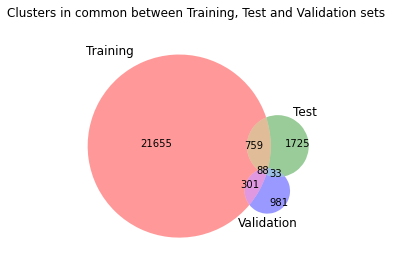

In [14]:
fig = plt.figure()
fig.patch.set_facecolor('white')
venn3([set(train.cl_name), set(test.cl_name), set(val.cl_name)], set_labels = ('Training', 'Test', 'Validation'))
plt.title('Clusters in common between Training, Test and Validation sets \n')
plt.show()

Rimuoviamo ora tutti i cluster con solo una sequenza

In questa figura, se un cluster ha 3 sequenze tutte nel test, allora sara un punto nell'insieme verde. Se invece ha 2 sequenze nel test e 1 nel training sara un punto nell'insieme marrone.

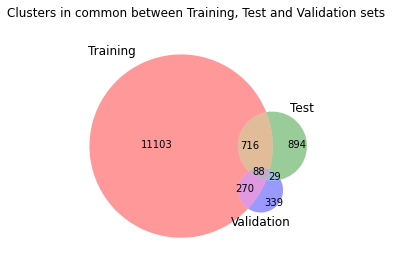

In [15]:
fig = plt.figure()
fig.patch.set_facecolor('white')
venn3([set(train[train.cl_name.isin(set(cl_filtered.cl_name))].cl_name), 
       set(test[test.cl_name.isin(set(cl_filtered.cl_name))].cl_name), 
       set(val[val.cl_name.isin(set(cl_filtered.cl_name))].cl_name)],
      set_labels = ('Training', 'Test', 'Validation'))
plt.title('Clusters in common between Training, Test and Validation sets \n')
plt.show()

##### Analizziamo se nella coppia non ci sono sempre 2 sequenze simili tra loro (questo sarebbe un bel problema perche con lo swappereccio la rete imparerebbe a distinguere le coppie uguali tra loro VS le coppie diverse tra loro).

In [16]:
d1 = pd.DataFrame(df.groupby('couple')['cl_name'].nunique()).reset_index()
d2 = pd.DataFrame(df.groupby('couple').count().gene).reset_index()
res = d1.merge(d2, on = 'couple')
res['equal'] = res.cl_name == res.gene

In [17]:
print(f'La percentuale di coppie che appartengono allo stesso cluster è pari a: {int(len(res[res.equal == False].couple.unique())/len(df.couple.unique()) * 100)}%')

La percentuale di coppie che appartengono allo stesso cluster è pari a: 1%


Ecco un esempio

In [18]:
df[df.couple == res[res['equal'] == False].iloc[0].couple]

,couple,gene,cl_name
32649,ENSG00000003402_ENSG00000205649,ENSG00000003402,2463
32650,ENSG00000003402_ENSG00000205649,ENSG00000205649,2463


# Full length

In [24]:
df

,couple,gene,cl_name
0,ENSG00000137074_ENSG00000170777,ENSG00000137074,0
1,ENSG00000137074_ENSG00000170777,ENSG00000170777,1
2,ENSG00000214031_ENSG00000248752,ENSG00000214031,2
3,ENSG00000214031_ENSG00000248752,ENSG00000248752,3
4,ENSG00000152580_ENSG00000233421,ENSG00000152580,4
...,...,...,...
342557,ENSMUSG00000025759_ENSMUSG00000088609,ENSMUSG00000088609,135648
342558,ENSMUSG00000031932_ENSMUSG00000076258,ENSMUSG00000076258,135648
342559,ENSMUSG00000055976_ENSMUSG00000076258,ENSMUSG00000076258,135648
342560,ENSMUSG00000037169_ENSMUSG00000087943,ENSMUSG00000087943,135648


In [26]:
df1 = pd.read_csv(os.path.join(processed_files_dir, 'cdhit_clusters_fl.csv')) #mmseq2_clusters.csv
df2 = pd.read_csv(os.path.join(processed_files_dir, 'cdhit_clusters_fl2.csv')) #mmseq2_clusters.csv
df1 = df[['couple', 'gene']].merge(df1)
df2 = df[['couple', 'gene']].merge(df2)
df1.to_csv(os.path.join(processed_files_dir, 'cdhit_clusters_fl_merged.csv'), index = False)
df2.to_csv(os.path.join(processed_files_dir, 'cdhit_clusters_fl2_merged.csv'), index = False)

In [27]:
clusters1 = df1.groupby('cl_name').count()[['couple']].reset_index()

In [33]:
print(f'Il numero totale di clusters è {clusters1.shape[0]}')

Il numero totale di clusters è 32456


In [28]:
clusters2 = df2.groupby('cl_name').count()[['couple']].reset_index()

In [34]:
print(f'Il numero totale di clusters è {clusters2.shape[0]}')

Il numero totale di clusters è 36121
